# Метод ближайших соседей

![](http://atkritka.com/upload/iblock/d8d/atkritka_1377378999_596.jpg)

Разберёмся как тренировать метод ближайших соседей в sklearn, заодно в очередной раз отработав типичную схему машинного обучения

![](https://upload.wikimedia.org/wikipedia/commons/e/e7/KnnClassification.svg)

In [54]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style='dark')

### Генерация данных

Сгенерируем данные

In [55]:
np.random.seed(13)
n = 100
a = np.random.normal(loc=0, scale=1, size=(n, 2))
b = np.random.normal(loc=3, scale=2, size=(n, 2))

Визуализируем полученный набор данных:

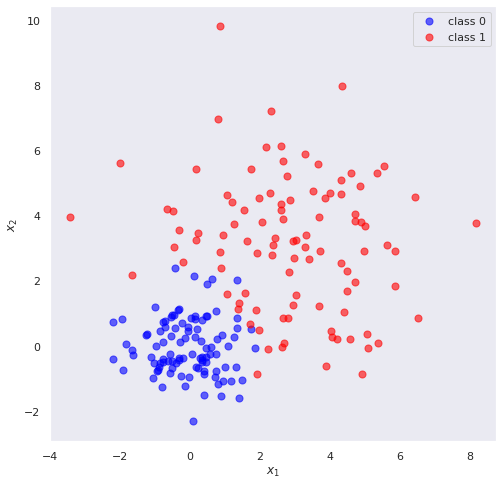

In [56]:
plt.figure(figsize=(8, 8))

plt.scatter(a[:, 0], a[:, 1], c='blue', s=50, alpha=0.6)
plt.scatter(b[:, 0], b[:, 1], c='red', s=50, alpha=0.6)

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(['class 0', 'class 1'], loc='upper right')

Объединим матрицы в единую матрицу данных и создадим отдельный столбец меток класса:

In [57]:
X = np.vstack([a, b])
y = np.hstack([np.zeros(n), np.ones(n)])

print (X.shape, y.shape)

(200, 2) (200,)


## Обучение моделей

Попробуем обучить разные варианты [метода ближайших соседей](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) из scikit-learn.

Для начала обучим метод 3 ближайших соседей

In [58]:
from sklearn.neighbors import KNeighborsClassifier as KNN

clf = KNN(n_neighbors=3)
clf.fit(X, y)
print (clf)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')


Предскажем метки для каких-нибудь точек

In [59]:
clf.predict([
             [2, 0],
             [10, 20],
             [-10, -20]
            ])

array([1., 1., 0.])

Предскажем вероятности каждой из меток

In [60]:
clf.predict_proba([
                   [2, 0],
                   [10, 20],
                   [-10, -20]
                   ])

array([[0.33333333, 0.66666667],
       [0.        , 1.        ],
       [1.        , 0.        ]])

А что, если мы хотим помотреть как обученный алгоритм проводит разделяющую поверхность между объектами из признакового пространства?

Для начала напишем функцию для генерации карты точек:

In [61]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01),
                       np.arange(y_min, y_max, 0.01))

In [62]:
def plot_model(X, y, clf, proba=False):
    clf.fit(X, y)
    xx, yy = get_grid(X)
    if proba:
        predicted = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
    else:
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.pcolormesh(xx, yy, predicted, cmap='bwr')
    plt.scatter(X[:, 0], X[:, 1], c=y, s=150, alpha=0.7, marker='H', edgecolors='black', cmap='bwr')
    plt.ylim([yy.min(),yy.max()])
    plt.xlim([xx.min(),xx.max()])
    return clf

Примерним классификатор к карте точек и визуализируем её

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

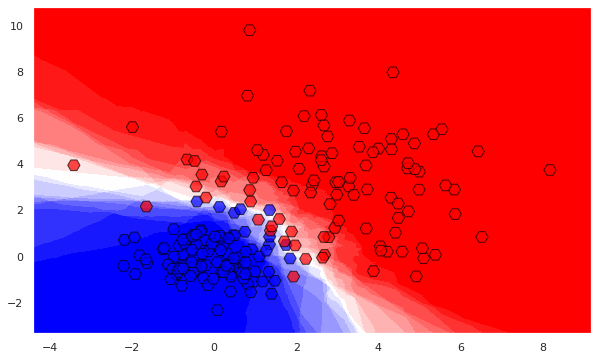

In [63]:
plt.figure(figsize=(10, 6))
plot_model(X, y, KNN(n_neighbors=20), proba=True)

Будем перебирать параметр число соседей и визуализировать полученное разбиение пространства объектов:

KNeighborsClassifier(algorithm='kd_tree', leaf_size=300, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=30, p=2,
                     weights='uniform')

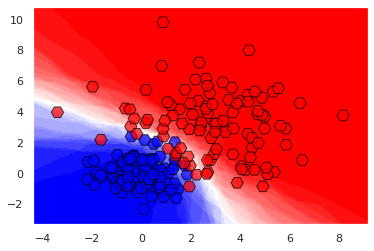

In [64]:
plot_model(X, y, KNN(n_neighbors=30, algorithm='kd_tree', leaf_size=300), proba=True)

## Как выбрать число соседей?

Разобьём данные на 2 части: обучение и контроль

In [65]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [66]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(140, 2) (140,)
(60, 2) (60,)


Оценим качество работы для n_neighbors=3

In [67]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, KNN(n_neighbors=3).fit(X_train, y_train).predict(X_test))

0.9333333333333333

Оценим качество для каждого из значений n_neighbors из [1, n) и построим график зависимости качества от n_neighbors

In [68]:
n = 100
scores = []
for k in range(1, n):
    scores.append(accuracy_score(y_test, KNN(n_neighbors=k).fit(X_train, y_train).predict(X_test)))

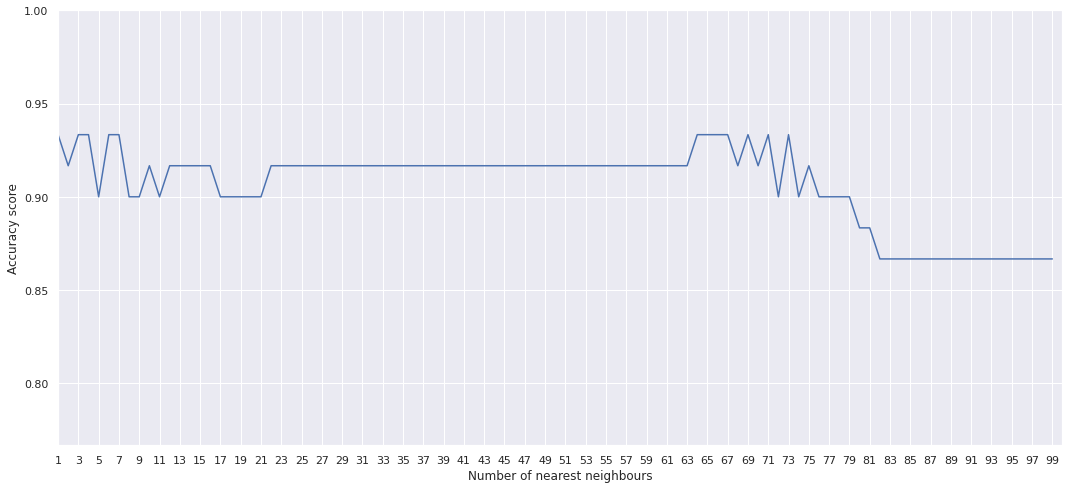

In [69]:
plt.figure(figsize=(18, 8))
plt.plot(range(1, n), scores)
plt.xlim(1, n)
plt.ylim(np.min(scores) - 0.1, 1)
plt.xticks(np.arange(1, n, 2))
plt.xlabel('Number of nearest neighbours')
plt.ylabel('Accuracy score')
plt.grid()

Из-за небольшого количества данных в тесте график получается шумным, и не до конца ясно, какое число соседей оптимально. Проведем кроссвалидацию средствами библиотеки sklearn

In [70]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors': range(1, n)}
grid_searcher = GridSearchCV(clf, params, cv=5)
grid_searcher.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=3, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': range(1, 100)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

Визуализируем полученные оценки качества и их $1\sigma$-доверительный интервал

In [71]:
df = pd.DataFrame(grid_searcher.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001304,0.000561,0.004787,0.001659,1,{'n_neighbors': 1},0.900,0.900,0.950,0.950,0.975,0.935,0.030000,26
1,0.000605,0.000207,0.002473,0.000430,2,{'n_neighbors': 2},0.925,0.925,0.950,0.950,0.950,0.940,0.012247,22
2,0.000634,0.000135,0.002627,0.000568,3,{'n_neighbors': 3},0.925,0.950,0.950,0.950,0.975,0.950,0.015811,5
3,0.000501,0.000025,0.002232,0.000161,4,{'n_neighbors': 4},0.925,0.925,0.975,0.975,0.975,0.955,0.024495,2
4,0.000471,0.000010,0.002110,0.000126,5,{'n_neighbors': 5},0.925,0.975,0.975,0.950,0.975,0.960,0.020000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.000379,0.000014,0.002443,0.000015,95,{'n_neighbors': 95},0.825,0.875,0.925,0.925,0.875,0.885,0.037417,90
95,0.000378,0.000026,0.002438,0.000042,96,{'n_neighbors': 96},0.800,0.850,0.925,0.925,0.875,0.875,0.047434,97
96,0.000361,0.000015,0.002589,0.000384,97,{'n_neighbors': 97},0.825,0.850,0.925,0.925,0.875,0.880,0.040000,95
97,0.000387,0.000014,0.002565,0.000118,98,{'n_neighbors': 98},0.800,0.825,0.925,0.900,0.875,0.865,0.046368,98


In [72]:
means = df['mean_test_score']
stds = df['std_test_score']
n_neighbors = df['params'].apply(lambda x: x['n_neighbors'])

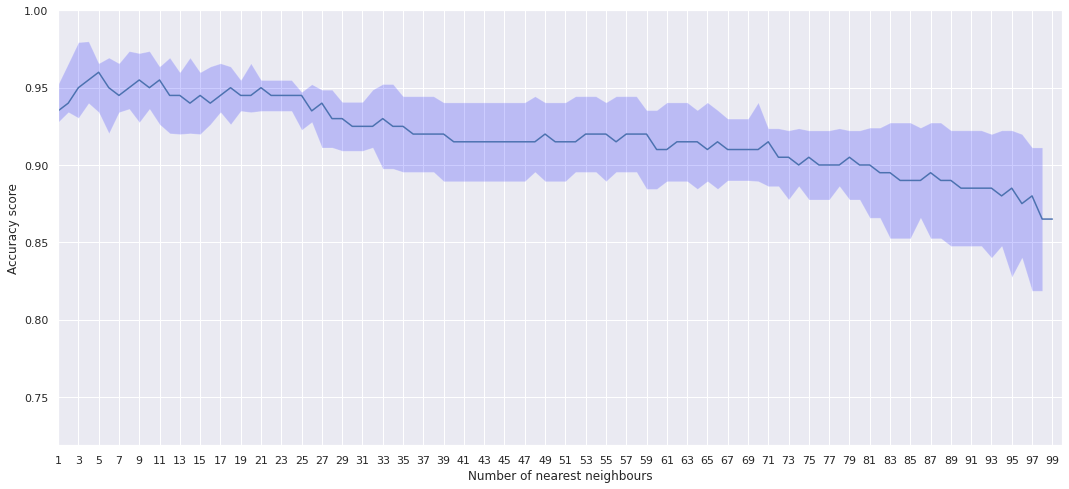

In [73]:
plt.figure(figsize=(18, 8))
plt.plot(n_neighbors, means)
plt.fill_between(range(len(means)), means + stds, means - stds, alpha = 0.2, facecolor='blue')
plt.xlim(1, n)
plt.ylim(np.min(means - stds) - 0.1, 1)
plt.xticks(np.arange(1, n, 2))
plt.xlabel('Number of nearest neighbours')
plt.ylabel('Accuracy score')
plt.grid()

## Какие параметры ещё можно настраивать?

Помимо числа соседей, мы можем подбирать следующие параметры:

1. weights ('uniform', 'distance', [callable])
2. metric 
3. p (для метрики Минковского)

Кроме того, у KNeighborsClassifier есть параметр algorithm, который отвечает за алгоритм поиска ближайших соседей, который может позволить ускорить работу по сравнению с наивным подходом:

1. Brute force
2. [BallTree](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree)
3. [KDTree](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree)
4. Auto

При использовании этих алгоритмов появляется и параметр для более детальной их настройки: leaf_size (для BallTree и KDTree)

## Масштабирование признаков

Загрузим набор данных [Wine](https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data), где требуется предсказать сорт винограда, из которого изготовлено вино, используя результаты химических анализов. Более подробное описание данных можно посмотреть [здесь](https://archive.ics.uci.edu/ml/datasets/Wine).

In [74]:
data = pd.read_csv('wine.data', header=None)
print(data.shape)
data.head()

(178, 14)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [75]:
data[0].value_counts()

2    71
1    59
3    48
Name: 0, dtype: int64

Сохраним отдельно матрицу объектов и столбец ответов

In [76]:
y = data[0].values
X = data.drop(0, axis=1).values
print(X.shape, y.shape)

(178, 13) (178,)


Подберём число соседей по кроссвалидации. Для этого напишем функцию, которая сделает это за нас

In [77]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def cv_nn(n_neighbors, X, y):
    average_scores = []
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    for k in n_neighbors:
        knn_clf = KNN(n_neighbors=k)
        scores = cross_val_score(knn_clf, X, y, cv=cv)
        average_scores.append(scores.mean())
    return average_scores

In [78]:
n_neighbors = range(1, 51)
average_scores = cv_nn(n_neighbors, X, y)

Посмотрим на то, что получилось:

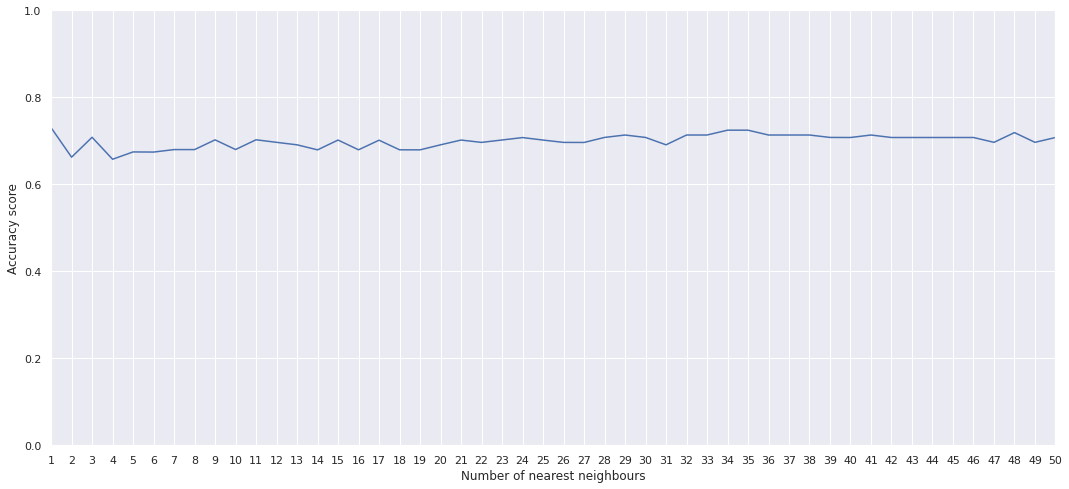

In [79]:
plt.figure(figsize=(18, 8))
l1 = plt.plot(n_neighbors, average_scores)
plt.xticks(n_neighbors)
plt.xlim(np.min(n_neighbors), np.max(n_neighbors))
plt.ylim(0, 1)
plt.xlabel('Number of nearest neighbours')
plt.ylabel('Accuracy score')
plt.grid()

А теперь сперва отмасштабируем данные и проделаем то же самое

In [80]:
from sklearn.preprocessing import scale
X_scaled = scale(X)
average_scores_scaled = cv_nn(n_neighbors, X_scaled, y)

Сравним полученные результаты

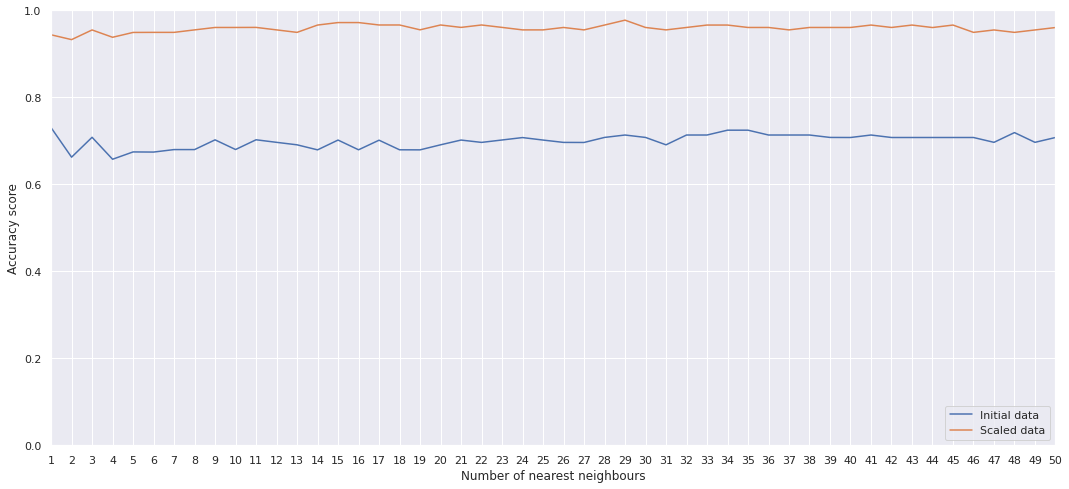

In [81]:
plt.figure(figsize=(18, 8))
l1 = plt.plot(n_neighbors, average_scores)
l2 = plt.plot(n_neighbors, average_scores_scaled)
plt.xticks(n_neighbors)
plt.xlim(np.min(n_neighbors), np.max(n_neighbors))
plt.ylim(0, 1)
plt.xlabel('Number of nearest neighbours')
plt.ylabel('Accuracy score')
plt.legend(['Initial data', 'Scaled data'], loc='lower right')
plt.grid()

Видно, что масштабирование данных сильно сказалось на качестве классификации.

## Проклятие размерности

![](https://2.downloader.disk.yandex.ru/preview/86e4c2752e9597d38721df7fcec530285080619a96d5304d4b18d968a593666a/inf/aeEgHcumGpaXdEIW73pGSkNH9oZwLkRa25vmf5WNu7beIcHlmoFmR7VTC8VdBFbIvJl-FABhBpMM1WVbnfLjJw%3D%3D?uid=165159067&filename=knn2.jpeg&disposition=inline&hash=&limit=0&content_type=image%2Fjpeg&tknv=v2&size=1838x922)

**Задание 1 (1 балл)**. Для того, чтобы прочувствовать проклятие размерности, сделайте следующее. Сгенерируйте $\ell$ точек равномерно по объёму $n$-мерного единичного куба с центром в нуле. Предположим, мы хотим протестировать метод ближайшего соседа для точки начала координат. Зададимся вопросом, на каком расстоянии будет ближайший сосед. Пусть $\ell=10000$. Постройте график зависимости медианы расстояния до ближайшего соседа (проведите генерацию несколько раз) от размерности $n$. 

In [259]:
### YOUR CODE HERE
n = 50   # razmernost
l = 10000  # points count
exp_count = 5
r = 1.0

points = np.random.uniform(low=-r, high=r, size=(exp_count, l, n))

In [260]:
def dist(p):
  return sum(x**2 for x in p) ** 0.5

def calc_closest_distance(points):
  return min(dist(p) for p in points)

def calc_mean_distance(points):
  return np.array([
    calc_closest_distance(points_exp)
    for points_exp in points
  ]).mean(axis=0)

In [261]:
mean_distance_closest_neibours_n = np.array([
  calc_mean_distance(points[:,:,:razmernost])
  for razmernost in range(1, n)
])

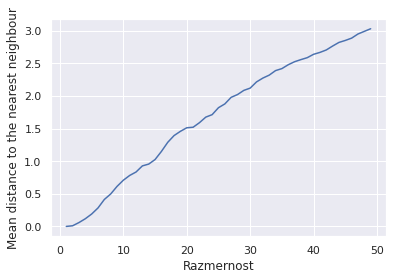

In [262]:
plt.plot(range(1, n), mean_distance_closest_neibours_n)
plt.xlabel('Razmernost')
plt.ylabel('Mean distance to the nearest neighbour')
plt.grid()

**Задание 2 (0.5 балла)**. Пусть $n=100$. Постройте анлогичный график завимисти медианы от количества точек $\ell$.

In [263]:
### YOUR CODE HERE
n = 100   # razmernost
l = 100  # points count
exp_count = 10
r = 1.0

points = np.random.uniform(low=-r, high=r, size=(exp_count, l, n))

In [264]:
mean_distance_closest_neibours_l = np.array([
  calc_mean_distance(points[:,:points_count,:])
  for points_count in range(1, l)
])

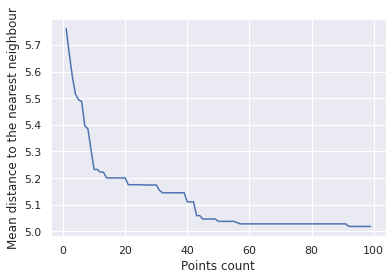

In [265]:
plt.plot(range(1, n), mean_distance_closest_neibours_l)
plt.xlabel('Points count')
plt.ylabel('Mean distance to the nearest neighbour')
plt.grid()

## Свой метод ближайших соседей

![](https://cdn-images-1.medium.com/max/800/1*otatqOkzhxFl4LXtkbDmhQ.jpeg)

**Задание 3  (1 балл)**. Реализуйте метод **одного** ближайшего соседа 1NN. Убедитесь, что он выдаёт на первой сегодняшней выборке такие же, как и встроенный алгоритм. Для этого нарисуйте разделяющую гиперплоскость, а также оцените качество для обоих алгоритмов.

**(+0.5 балла)** Реализуйте интерфейс классификатора sklearn и измерьте качество встроенными способами.

In [84]:
from sklearn.base import BaseEstimator, ClassifierMixin

class TemplateClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        pass